# Leon Dailani Corners Challenge - Two Negative Binomial Models

The following notebook constitutes my submission to the Mustard Systems' Corners Challenge. I am using a Jupyter Notebook to clearly demonstrate the code and data manipulation that I've decided to undertake and also to give me the opoprtunity to more thorughly explain my decision making process.

## Summary Question Answers:

1)

I've fitted two GLMs using a negative binomial distribution with a logarithmic link function to predict home and away corners separately. This bivariate approach produced models with the lowest relative AIC scores and the best mean squared error. The distribution of the corners was assumed to follow a negative binomial since they are discrete count data but exhibit overdispersion (variance greater than the mean), meaning a Poisson distribution would be inappropriate. I plotted a histogram of the data and used a QQ plot to determine this.

Feature selection for the model was conducted using a Random Forest to determine feature importance. I separated the Data column into DayOfWeek, Month, and Year column entries that could be used to gauge whether corners showed seasonal dependence. I also created a PastGoalsAvg feature, which was the combined total historical average goals scored by both teams. This feature showed strong importance, likely as it's indicative of how aggressive a team's playstyle is. The more goals historically scored by a team on average, the more aggressively it is likely to play, and thus the more corners it is likely to win. The Month was also shown to be a good predictor; this may be because of increased pressure placed on teams towards the end of the league. Teams in title contention may play more aggressively and gain more corners in the spring/summer months when goal difference or a small number of points separates them from the title or a Champions League spot. PastGoalsAvg was used as a float, and seasonal/matchup data as categorical. The GLM was useful here in enabling the combination of multiple data types.

2)

The probability of being under/at/over the supplied line was determined by using the predicted mean total corners from the match and using that as the negative binomial parameter. CDF and PMF were then used to populate the probability columns.

3)

I decided to take a bet on the match based on the expected value. The bet with the greater expected value was preferred. The staking amount was determined using the Kelly Criterion.


Improvements in the future:

The model seems to really prefer the under bet. I think this might be an issue with the way I have implemented the negative binomial model by assuming the dispersion factor. This is a bit of quirk with the python package that I used so it might be easier do to this in R in the future. I could have tried using just a standard bivariate poisson ditribution to see if that is better or I could've tried some more advanced discrete distributions. I could've tried cutting/using more features for these different distributions and seen which one models the corners better.

Of course, more data/features would've most likely been useful.

I am not entirely sure whether my implementation of the Kelly Criterion is correct and whether my bankroll caluclations are appropriate either.


## Step 1: Data Exploration and Distribution of Target Variable

The first step to tackling the challenge involves investigating the data. To do this, I will set up the necessary notebook environment through importing the necessary librarires and loading the data. I will then examine the data and have a look at the distributions in order to gain an understanding of the potential relationships between the variables.

In [1]:
# Importing necessary quantiative analysis python modules
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns


# Settings for better readability in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid")

In [2]:
# Import data as pandas dataframes from their original csv format
# The test and train csv files are stored in the same directory as the notebook

test_df = pd.read_csv("test (15).csv")
train_df = pd.read_csv("train (15).csv")

In [3]:
# Taking a look at the first few rows of the training data
train_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners
0,2826,793,02/04/2005,410,908,2.00,0.00,15,1
1,2827,793,02/04/2005,338,597,3.00,2.00,3,6
2,2828,793,02/04/2005,1364,246,2.00,3.00,13,2
3,2829,793,02/04/2005,1088,1397,1.00,0.00,2,5
4,2830,793,02/04/2005,830,1412,2.00,3.00,3,6


Can see from the table that the following information is present:

- a unique MatchId
- a LeagueId which relates to which sports league the football game was played in
- a Date for when the match is played
- a unique HomeTeamId and AwayTeamId that uniquely identifies the different teams playing in the match and is consistent in other matches they play
- Home_Goals and Away_Goals which gives the number of goals scored by the home and away teams respectively 
- Home_Corners and Away_Corners which gives the number of corners attained by the home and away team respectively

First it is important to clean the data: checking for any null / missing values and cleaning them accordingly

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23830 entries, 0 to 23829
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MatchId       23830 non-null  int64  
 1   LeagueId      23830 non-null  int64  
 2   Date          23830 non-null  object 
 3   HomeTeamId    23830 non-null  int64  
 4   AwayTeamId    23830 non-null  int64  
 5   Home_Goals    23822 non-null  float64
 6   Away_Goals    23822 non-null  float64
 7   Home_Corners  23830 non-null  int64  
 8   Away_Corners  23830 non-null  int64  
dtypes: float64(2), int64(6), object(1)
memory usage: 1.6+ MB


In [5]:
train_df.isnull().sum()

MatchId         0
LeagueId        0
Date            0
HomeTeamId      0
AwayTeamId      0
Home_Goals      8
Away_Goals      8
Home_Corners    0
Away_Corners    0
dtype: int64

We can see that there are 8 match records with null values for their goals. As there is a lot of data present, we can comfortably just remove these 8 recrds without loss of predictive power.

In [6]:
# Dropping rows with missing values
train_df.dropna(inplace=True)

In [7]:
train_df.dtypes

MatchId           int64
LeagueId          int64
Date             object
HomeTeamId        int64
AwayTeamId        int64
Home_Goals      float64
Away_Goals      float64
Home_Corners      int64
Away_Corners      int64
dtype: object

Next, let's look at the distribution of the target variables. Since we are interested in predicting the number of corners, let's examine the distribution of these counts. 

Given that corners are a form of integer count data ranging from 0 to a reasonably small number, the current working assumption is that the data will be distributed like a poisson distribution.Indeed, a poisson distribution is a discrete probability distributoin that describes the probability of the number of events within a specific time period (90 minutes for a football game) with a known average rate of occcurence. It's a good assumption to make that corners follow this distribution:

P(x)=$\frac{e^{-\lambda}\lambda^x}{x!} , \lambda >0$

However, in reality the corners could show variance greater of less than the mean signifying a perfect poisson distribution is not followed. Dispersion could be caused by team strategy, the refs or weather which would all mean that the number of corners would be more variable than predicted by a poisson distribution.

In [8]:
# Calculate mean and variance for Home and Away Corners
home_corners_mean = train_df['Home_Corners'].mean()
home_corners_variance = train_df['Home_Corners'].var()

away_corners_mean = train_df['Away_Corners'].mean()
away_corners_variance = train_df['Away_Corners'].var()

print(f"Home Corners Mean: {home_corners_mean}, Variance: {home_corners_variance}")
print(f"Away Corners Mean: {away_corners_mean}, Variance: {away_corners_variance}")

Home Corners Mean: 5.725841658970699, Variance: 8.087925438677539
Away Corners Mean: 4.493493409453446, Variance: 6.276667288462503


Looking at the mean and standard deviation, we can see that we have over-dispersion of corners. In this case, it would be useful to model corners using a negative binomial distribution which introduces an extra parameter than poisson. that allows for the variance to be greater than the mean.

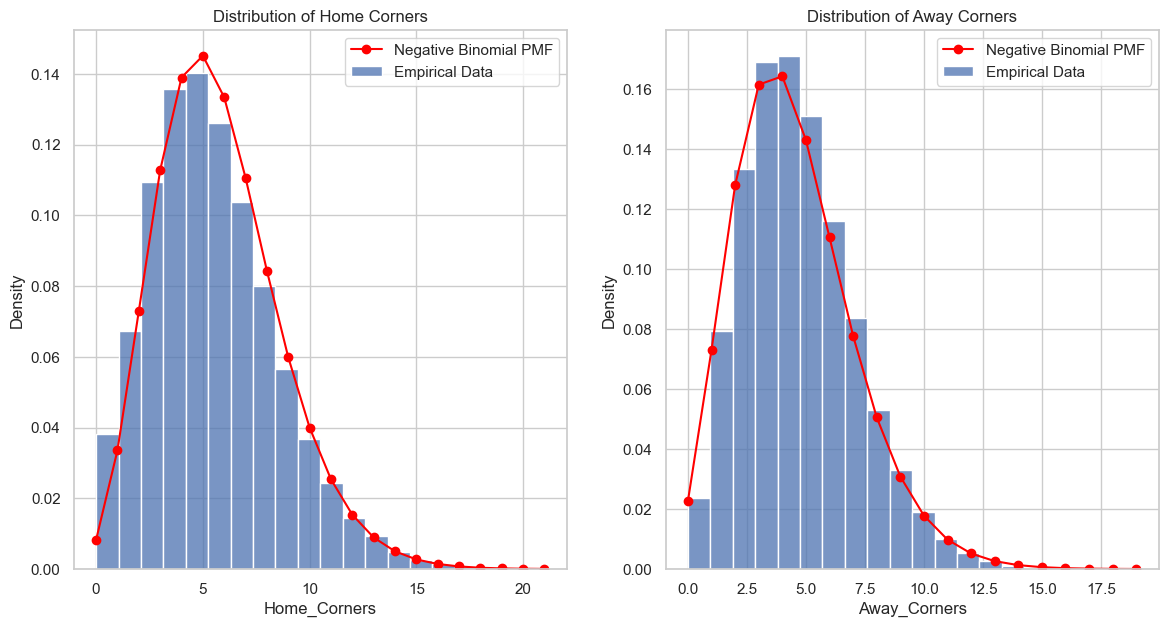

In [9]:
# Distribution of home and away corners as a histogram
# overlaying a negative binomial distribution onto it

# Estimate parameters for negative binomial distribution
# r is the number of successes, p is the probability of success
r_home = home_corners_mean**2 / (home_corners_variance - home_corners_mean)
p_home = home_corners_mean / home_corners_variance
r_away = away_corners_mean**2 / (away_corners_variance - away_corners_mean)
p_away = away_corners_mean / away_corners_variance

# defining a domain for the poisson pmf and defining it
x_home = np.arange(0,train_df['Home_Corners'].max()+1)
nbinom_pmf_home = st.nbinom.pmf(x_home, r_home, p_home)
x_away = np.arange(0,train_df['Away_Corners'].max()+1)
nbinom_pmf_away = st.nbinom.pmf(x_away, r_away, p_away)

# plot the histogram and negative binomial distribution onto each other

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(train_df['Home_Corners'], bins=20, kde=False, stat='density', label='Empirical Data')
plt.plot(x_home, nbinom_pmf_home, 'o-', label='Negative Binomial PMF', color = 'red')
plt.title('Distribution of Home Corners')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(train_df['Away_Corners'], bins=20, kde=False, stat='density', label='Empirical Data')
plt.plot(x_away, nbinom_pmf_away, 'o-', label='Negative Binomial PMF', color='red')
plt.title('Distribution of Away Corners')

plt.legend()
plt.show()


For a poisson distribution, the variance should equal the mean. This is approximately the case here and this is reinforced when looking at the histogram plot of the empirical corner data against the poisson distribution with lambda parameters equal to the means of the home and away goals.

The corner count needed to be converted to density to account for the poisson being a porbability distribution. Can see a good level of agreement between the poisson distribution and the dataset.

Let's verify this distribution another way.

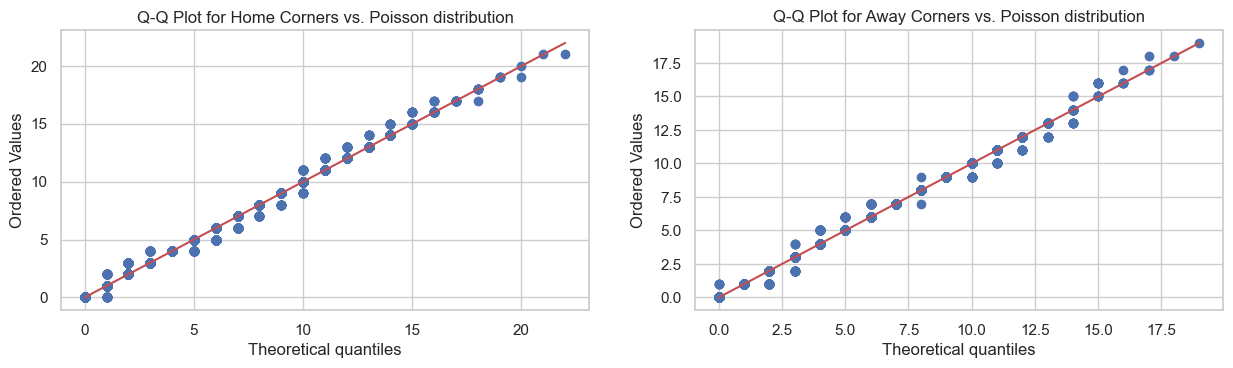

In [10]:
from scipy.stats import probplot

# Generate a Q-Q plot for the Home Corners
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(2, 2, 1)
probplot(train_df['Home_Corners'], dist="nbinom", sparams=(r_home,p_home), plot=ax1)
ax1.set_title('Q-Q Plot for Home Corners vs. Poisson distribution')

# Do the same for the Away Corners
ax2 = fig.add_subplot(2, 2, 2)
probplot(train_df['Away_Corners'], dist="nbinom", sparams=(r_away,p_away), plot=ax2)
ax2.set_title('Q-Q Plot for Away Corners vs. Poisson distribution')
plt.show()


A Q-Q plot compares the quantiles of the empirical data to the quantiles of the theoretical poisson dstribution. The plots above show good agreement between the thery and the data.

## Step 2: Feature Engineering and Data Preprocessing

We must ensure that data is is the right format by performing prreprocessing and then we can isolate features from the data to improve model performance such as team-specific historical performance, league-specific averages and seasonality.

In [11]:
# Create a new column for total corners
# train_df['Total_Corners'] = train_df['Home_Corners'] + train_df['Away_Corners']

In [12]:
# Let's ensure they are treated as categorical for any operations that require it.
for col in ['LeagueId', 'HomeTeamId', 'AwayTeamId']:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

In [13]:
# The date can capture trends and seasonaity which could be predictive of the number of corners
train_df['Date'] = pd.to_datetime(train_df['Date'], dayfirst=True)
# Extract date features and create new columns for it
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['DayOfWeek'] = train_df['Date'].dt.dayofweek

test_df['Date'] = pd.to_datetime(test_df['Date'],dayfirst=True)
test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['DayOfWeek'] = test_df['Date'].dt.dayofweek 



Goals cannot be used as a predictor in the model as these are not known for future games, however, they are likely to have a big predictive power when used as an indicator of team strength/ playstyle. A team that historically scores more goals is likely to have a more offensive playstyle and thus score more corners too.

In [14]:
# Calculate the historical average goals scored for home and away teams
home_goals_avg = train_df.groupby('HomeTeamId')['Home_Goals'].mean().to_dict()
away_goals_avg = train_df.groupby('AwayTeamId')['Away_Goals'].mean().to_dict()

# Create new features for the average goals for the home and away teams
train_df['HomeTeamGoalsAvg'] = train_df['HomeTeamId'].map(home_goals_avg)
train_df['AwayTeamGoalsAvg'] = train_df['AwayTeamId'].map(away_goals_avg)

# Add it to the test_df
test_df['HomeTeamGoalsAvg'] = test_df['HomeTeamId'].map(home_goals_avg)
test_df['AwayTeamGoalsAvg'] = test_df['AwayTeamId'].map(away_goals_avg)


/var/folders/gp/7rlcs1qs55g_8dls4p0r9dlc0000gn/T/ipykernel_71112/1868888751.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  home_goals_avg = train_df.groupby('HomeTeamId')['Home_Goals'].mean().to_dict()
/var/folders/gp/7rlcs1qs55g_8dls4p0r9dlc0000gn/T/ipykernel_71112/1868888751.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  away_goals_avg = train_df.groupby('AwayTeamId')['Away_Goals'].mean().to_dict()


In [15]:
train_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,Year,Month,DayOfWeek,HomeTeamGoalsAvg,AwayTeamGoalsAvg
0,2826,793,2005-04-02,410,908,2.00,0.00,15,1,2005,4,5,1.33,1.20
1,2827,793,2005-04-02,338,597,3.00,2.00,3,6,2005,4,5,1.32,0.99
2,2828,793,2005-04-02,1364,246,2.00,3.00,13,2,2005,4,5,1.70,1.03
3,2829,793,2005-04-02,1088,1397,1.00,0.00,2,5,2005,4,5,1.53,0.95
4,2830,793,2005-04-02,830,1412,2.00,3.00,3,6,2005,4,5,1.31,1.33


## Step 3: Feature selection

Before constructing a model, it is necessary to first identify the predictor variables that are to be used in the model.

There are multiple different ways of identifying good features for a model but I am going to take a tree-based model approach using Random Forests. This technique can be used to estimate feature importance by minimising impurity when combining features. For a regression model as would be needed for prediciting corners, the impurity to minimsie is variance.

It is first important to split the dataset into a training subset to train the model and a test subset to validate the model. This is important to prevent overfitting and to allow model testing.


### Fitting a model first for home corners

In [16]:
from sklearn.model_selection import train_test_split


# Define the features (X) and the target (y)
# Dropping non-predictive and target columns
# Goals cannot be used as a predictor as we won't know these for a future game
# Year cannot be used as a predictor as the model won't know how to handle future years
X = train_df.drop(['MatchId', 'Date','Home_Corners','Away_Corners','Home_Goals','Away_Goals','Year'], axis=1)  
y = train_df['Home_Corners']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)


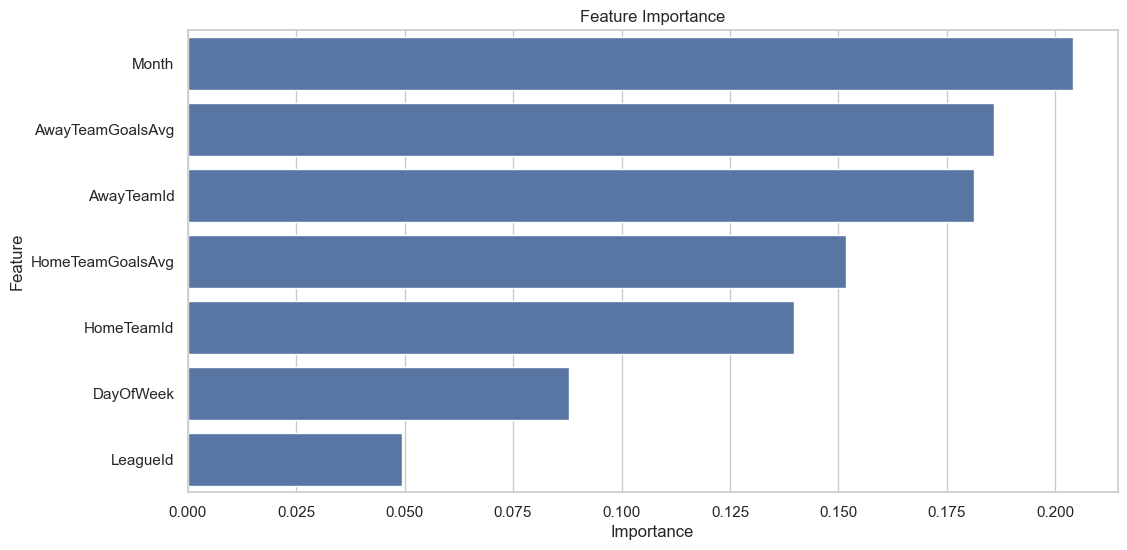

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Fit a Random Forest to the data
rf = RandomForestRegressor(n_estimators=100,random_state=4)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Plot feature importances
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


Here we have ranked the most important features as determined by the random forest and can see that which home and away teams play are the most important predictors for total number of corners.

We can now use this feature importance to select for the best set of features. There are many ways to select features from importance values but I am going to use an approach of selecting features that have an importance above the mean importance.

In [18]:
selected_feature_df = feature_importance_df[feature_importance_df['Importance'] > 0.1]
selected_feature_df

,Feature,Importance
3,Month,0.20
6,AwayTeamGoalsAvg,0.19
2,AwayTeamId,0.18
5,HomeTeamGoalsAvg,0.15
1,HomeTeamId,0.14


We must remeber that for predicting future corners, we won't have future goals so we have to remove those features from consideration. Hence, we select HomeTeamId, AwayTeamId and Month, DayOfWeek.

In [19]:
# Defining a variable containing the list of selected features
selected_features = list(selected_feature_df['Feature'])
# selected_features = list(feature_importance_df['Feature'])
selected_features
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
X_train

,Month,AwayTeamGoalsAvg,AwayTeamId,HomeTeamGoalsAvg,HomeTeamId
18822,11,0.78,1194,1.31,1222
4524,8,0.94,526,1.55,442
7156,6,1.16,916,1.71,489
19342,3,0.88,1251,1.29,861
12046,7,0.86,345,1.16,353
...,...,...,...,...,...
11863,7,1.06,410,1.84,1740
22407,9,0.55,5501,0.90,4832
17093,8,1.60,216,2.15,324
8366,9,1.04,1386,1.47,232


## Step 4: Model Building

To build the model I will use a GLM as it is capable of simultaneously handling differing data types. I will use a negative binomial distribution.

Now that we have selected these features, it is important to prepare the test_df accordingly so that it mirrors the feature space of the training data.

In [20]:
import statsmodels.api as sm
import os
from statsmodels.formula.api import glm
from statsmodels.genmod.families import NegativeBinomial
import pickle

# Convert categorical variables to string type for the formula interface
X_train[['Month','AwayTeamId','HomeTeamId']] = X_train[['Month','AwayTeamId','HomeTeamId']].astype(str)
X_valid[['Month','AwayTeamId','HomeTeamId']] = X_valid[['Month','AwayTeamId','HomeTeamId']].astype(str)

# Create the formula string for the regression model
formula_str = 'Home_Corners ~ ' + ' + '.join(X_train.columns)

# Path to the model file
model_path = 'home_corner_model_new.pkl'
# Check if the model file exists
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        home_corner_model = pickle.load(file)
else:

    # Fit the model with the training set as before
    home_corner_model = glm(formula=formula_str, data=X_train.join(y_train), family=NegativeBinomial()).fit()
    with open(model_path, 'wb') as file: 
        pickle.dump(home_corner_model, file)


In [21]:
X_valid['prediction'] = home_corner_model.predict(X_valid)

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_valid, X_valid['prediction'])
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_valid, X_valid['prediction'])
print(f'Mean Squared Error: {mse}')


Mean Absolute Error: 2.210130106000131
Mean Squared Error: 8.17554306474492


Repeating the same for an away corner model:

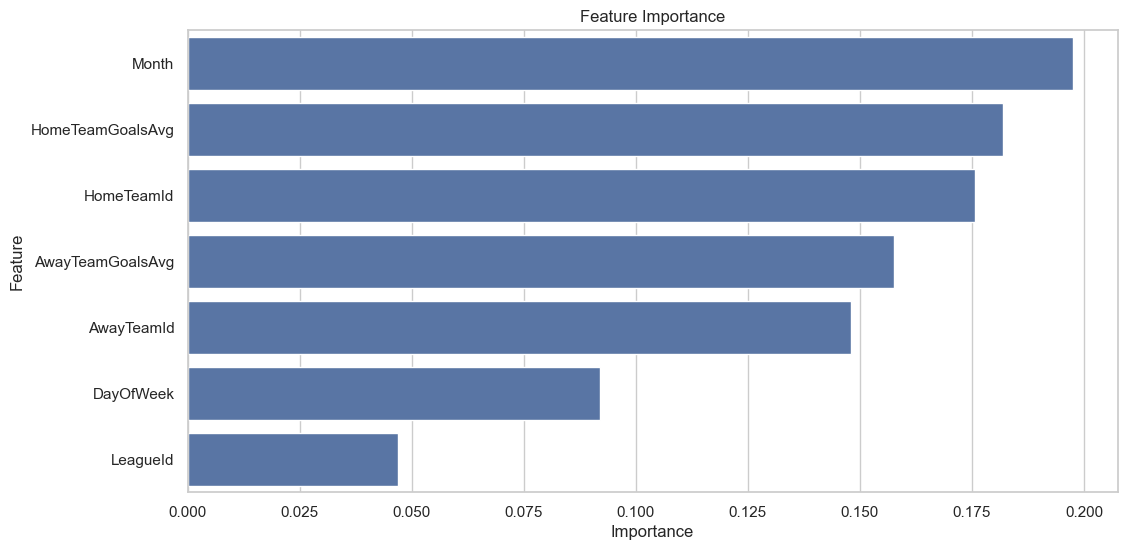

In [23]:
# Away corner model

# Define the features (X) and the target (y)
# Dropping non-predictive and target columns
# Goals cannot be used as a predictor as we won't know these for a future game
# Year cannot be used as a predictor as the model won't know how to handle future years
X = train_df.drop(['MatchId', 'Date','Home_Corners','Away_Corners','Home_Goals','Away_Goals','Year'], axis=1)  
y = train_df['Away_Corners']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=4)


# Fit a Random Forest to the data
rf = RandomForestRegressor(n_estimators=100,random_state=4)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into a DataFrame
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Plot feature importances
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')

selected_feature_df = feature_importance_df[feature_importance_df['Importance'] > 0.1]
selected_features = list(selected_feature_df['Feature'])
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]

# Convert categorical variables to string type for the formula interface
X_train[['Month','AwayTeamId','HomeTeamId']] = X_train[['Month','AwayTeamId','HomeTeamId']].astype(str)
X_valid[['Month','AwayTeamId','HomeTeamId']] = X_valid[['Month','AwayTeamId','HomeTeamId']].astype(str)

# Create the formula string for the regression model
formula_str = 'Away_Corners ~ ' + ' + '.join(X_train.columns)

# Path to the model file
model_path = 'away_corner_model_new.pkl'
# Check if the model file exists
if os.path.exists(model_path):
    with open(model_path, 'rb') as file:
        away_corner_model = pickle.load(file)
else:

    # Fit the model with the training set as before
    away_corner_model = glm(formula=formula_str, data=X_train.join(y_train), family=NegativeBinomial()).fit()
    with open(model_path, 'wb') as file: 
        pickle.dump(away_corner_model, file)


In [24]:
X_valid['prediction'] = away_corner_model.predict(X_valid)
mae = mean_absolute_error(y_valid, X_valid['prediction'])
print(f'Mean Absolute Error: {mae}')

mse = mean_squared_error(y_valid, X_valid['prediction'])
print(f'Mean Squared Error: {mse}')

Mean Absolute Error: 1.8939397348204743
Mean Squared Error: 5.7403156261610455


## Step 5: Predicting Corners

To calculate the probabilities $P(Under), P(At), and P(Over)$ for the test set, I will need to consider the distribution of predicted total corners from your model.These can be calculated using a pmf and cdf of the negative binomial distribution.

The CDF will give  the probability of observing a number of corners less than or equal to the line (which is used to calculate $P(Under)  and P(Over)$, and the PMF gives $P(At)$.

First, we must prepare the test_df and add the predicted number of corners from the model.

In [25]:
test_df[['Month','AwayTeamId','HomeTeamId']] = test_df[['Month','AwayTeamId','HomeTeamId']].astype(str)
test_df = test_df.drop('Unnamed: 8',axis=1)

In [26]:
test_df['AwayCornerPredict'] = away_corner_model.predict(test_df[selected_features])
test_df['HomeCornerPredict'] = home_corner_model.predict(test_df[selected_features])
test_df['TotalCornerPredict'] = test_df['AwayCornerPredict'] + test_df['HomeCornerPredict']

Then, we must gather the relevant parameters for the negative binomial model in order to establish the probabilities using a cdf and pmf. These parameters come from the definition of a negative binomial model.

In [27]:
# The dispersion parameter 'alpha' can be estimated from the model:
alpha = home_corner_model.scale
predicted_means = test_df['TotalCornerPredict']
# The variance of the negative binomial distribution can be calculated fr
predicted_variances = predicted_means + alpha * predicted_means**2
# Now, to find 'n' and 'p', you can use the mean and variance formulas fo
# mean = n * (1 - p) / p
# variance = n * (1 - p) / p^2
# Solving these equations gives us:
p = predicted_means / predicted_variances 
n = (predicted_means * p)/(1-p)
test_df['n'] = n 
test_df['p'] = p

In [28]:
# Calculate probabilities
for index, row in test_df.iterrows(): 
    line = row['Line']
    n = row['n']
    p =row['p']

  # The cumulative distribution function (CDF) will give us P(X <= x)
    # For P(Under), we want P(X < line), which is P(X <= line - 1) for an integer line
    if line.is_integer():
        test_df.loc[index, 'P(Under)'] = st.nbinom.cdf(line - 1, n, p)
        test_df.loc[index, 'P(At)'] = st.nbinom.pmf(line, n, p)
    else:
        # For a non-integer line, P(Under) is P(X <= floor(line))
        test_df.loc[index, 'P(Under)'] = st.nbinom.cdf(int(line), n, p)
        test_df.loc[index, 'P(At)'] = 0.0
    
    # P(Over) is simply 1 - P(X <= line)
    test_df.loc[index, 'P(Over)'] = 1 - st.nbinom.cdf(line, n, p)

# Note: P(At) is not calculated for non-integer lines as it's always 0.

## Step 6: Calculating EV and Stake

Deciding on whether to take an over or under bet is given by comparing the expected value of etither bet and seeing which is bigger. We must account for the possibility of a push bet in our equation.

The stake can be calculted using the Kelly Criterion which gives the fraction of the bankroll to bet. The Kelly Criterion gives a good balance between risk and reward.

Taking the bankroll to be £1000

In [29]:
bankroll = 1000

# Function to calculate expected value, including the probability of a push
def expected_value(odds, probability_win, probability_push):
    probability_lose = 1 - probability_win - probability_push
    return (odds) * probability_win + probability_push - probability_lose

# Function to calculate the kelly criterion
def kelly_stake(odds, probability_win, probability_push, bankroll):
    b = odds - 1
    q = 1 - probability_win - probability_push  # Adjusting Q for the probability of a push
    fraction = max(min((probability_win * b - q) / b, 1), 0)  # Fraction between 0 and 1
    return bankroll * fraction

I can then use these functions to populate the columns in test_df approrpiately.

In [30]:
for index, row in test_df.iterrows():
    # Calculate expected value for both over and under bets
    ev_over = expected_value(row['Over'], row['P(Over)'], row['P(At)'])
    ev_under = expected_value(row['Under'], row['P(Under)'], row['P(At)'])

    # Decide on the bet
    if ev_over > ev_under and ev_over > 0:
        test_df.at[index, 'Bet (U/O)'] = 'O'
        stake = kelly_stake(row['Over'], row['P(Over)'], row['P(At)'], bankroll)
    elif ev_under > ev_over and ev_under > 0:
        test_df.at[index, 'Bet (U/O)'] = 'U'
        stake = kelly_stake(row['Under'], row['P(Under)'], row['P(At)'], bankroll)
    else:
        test_df.at[index, 'Bet (U/O)'] = 'No Bet'
        stake = 0

    test_df.at[index, 'Stake'] = np.round(stake,2)

/var/folders/gp/7rlcs1qs55g_8dls4p0r9dlc0000gn/T/ipykernel_71112/2241169529.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'U' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_df.at[index, 'Bet (U/O)'] = 'U'


The final step is to remove all the feature information from test_df and to output a final complete csv with all the requisite betting information.

In [31]:
test_df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Line,Over,Under,P(Under),P(At),P(Over),Bet (U/O),Stake,Year,Month,DayOfWeek,HomeTeamGoalsAvg,AwayTeamGoalsAvg,AwayCornerPredict,HomeCornerPredict,TotalCornerPredict,n,p
0,1,741,2011-04-01,342,694,9.50,1.79,1.80,0.63,0.00,0.37,U,175.82,2011,4,4,1.74,2.27,5.39,4.07,9.47,1.00,0.10
1,2,741,2011-04-01,1424,270,11.50,1.92,2.00,0.63,0.00,0.37,U,256.86,2011,4,4,1.97,1.24,4.81,6.81,11.63,1.00,0.08
2,3,729,2011-04-01,691,1137,10.50,1.97,1.87,0.61,0.00,0.39,U,170.78,2011,4,4,1.35,1.05,6.01,5.05,11.06,1.00,0.08
3,4,729,2011-04-01,787,808,11.00,2.08,1.77,0.63,0.03,0.33,U,199.01,2011,4,4,1.65,1.43,5.54,4.92,10.47,1.00,0.09
4,5,741,2011-04-01,784,1117,12.00,2.02,1.86,0.63,0.03,0.34,U,228.07,2011,4,4,3.18,1.05,4.49,7.18,11.67,1.00,0.08


In [32]:
complete_df = test_df.drop(['Year','Month','DayOfWeek','HomeTeamGoalsAvg','AwayTeamGoalsAvg','HomeCornerPredict','AwayCornerPredict','n','p'],axis=1) 
complete_df.to_csv('Leon_Dailani_Complete_Corners_Challenge.csv',index=False)